In [7]:
import genericpath

import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class YogaPoseDataset(Dataset):
	def __init__(self, dataset_path, size=(256, 192), transform=None):
		self.data_path = dataset_path
		self.size = size
		self.transform = transform

		# call to init the data
		self._init_data()

	def _init_data(self):
		images = list()

		for _, directory_class in enumerate(os.listdir(self.data_path)):
			class_path = os.path.join(self.data_path, directory_class)
			for file_name in os.listdir(class_path):
				f = cv2.imread(os.path.join(class_path, file_name), cv2.IMREAD_COLOR)
				f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

				if self.transform is not None:
					f = self.transform(f)

				data = torch.reshape(torch.FloatTensor(f).to(device), (3, self.size[0], self.size[1]))

				# format example  images[x][0] -> (label, input)
				# format example  images[x][1] -> [other information]
				# images[x] -> ((class_id, image_tensor), [filename])
				images.append((int(directory_class), data))

		# np.random.shuffle(images)
		self.images = images

	def __len__(self):
		# returns the number of samples in our dataset
		return len(self.images)

	def getData(self):
		return self.images

	def get_value(self, idx):
		return self.images[idx]

	def __getitem__(self, key):
		return self.get_value(key)

	def getOriginalImage(self, idx):
		img_vis = self.get_value(idx)[1]
		#std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(-1).unsqueeze(-1)
		#mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(-1).unsqueeze(-1)
		#img_vis = imv_vis * std + mean
		return img_vis

	def collate_fn(self, data):
		Xs = torch.stack([x[1] for x in data])
		y = torch.stack([torch.tensor(x[0]) for x in data])
		return Xs, y

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force working on cpu due to memory limitation
device= torch.device("cpu")
DATASET_PATH = './data/images/'
ANNOTATION_PATH = './data/annotations/'
MODEL_NAME = "tpr_a4_256x192"
# get model from torch hub
assert MODEL_NAME in ["tpr_a4_256x192", "tph_a4_256x192"]

model = torch.hub.load('yangsenius/TransPose:main', MODEL_NAME, pretrained=True)
model.to(device)
norm_transform = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])
dataset = YogaPoseDataset(DATASET_PATH, transform=norm_transform)

Using cache found in /home/orlando/.cache/torch/hub/yangsenius_TransPose_main


>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_r_256x192_enc4_d256_h1024_mh8.pth
Successfully loaded model  (on cpu) with pretrained weights!


In [9]:
split_position = int((len(dataset) // 10) * 7)
trainset = dataset[:split_position]
print(len(trainset))
testset = dataset[split_position:]
print(len(testset))

4193
1799


In [10]:
from TransPose.lib.config import cfg
from TransPose.lib.core.inference import get_final_preds
from TransPose.lib.utils import transforms
from TransPose.visualize import inspect_atten_map_by_locations

In [11]:
OUT_DIR = "./out/"
idx = 1

if not os.path.isdir(OUT_DIR):
	os.makedirs(OUT_DIR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/orlando/anaconda3/envs/AML_env/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


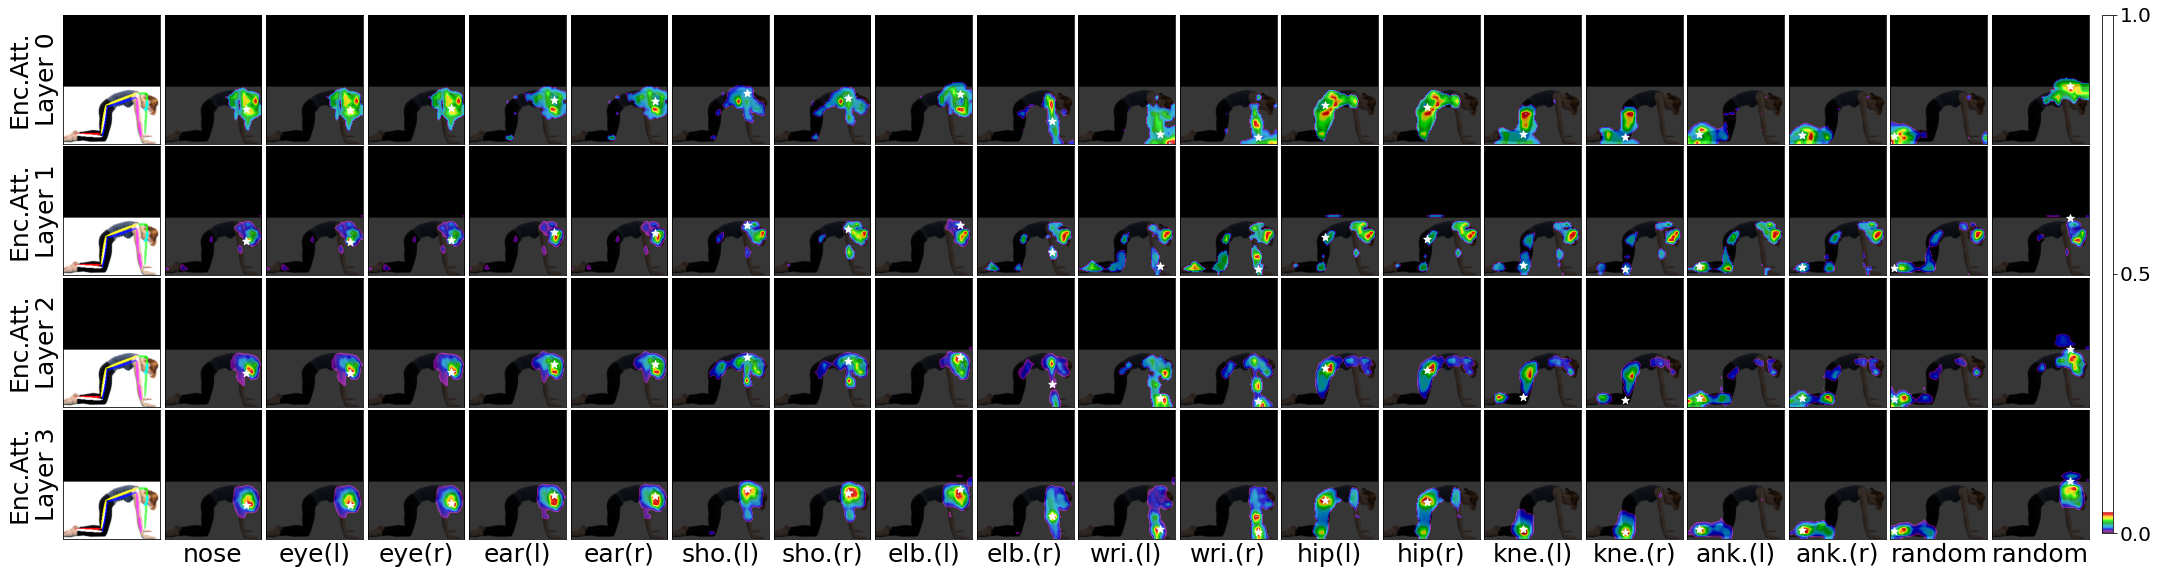

In [12]:
with torch.no_grad():
	model.eval()
	img = dataset[idx][1]

	inputs = torch.cat([img.to(device)]).unsqueeze(0)
	outputs = model(inputs)

	if isinstance(outputs, list):
		output = outputs[-1]
	else:
		output = outputs

	if cfg.TEST.FLIP_TEST:
		input_flipped = np.flip(inputs.cpu().numpy(), 3).copy()
		input_flipped = torch.from_numpy(input_flipped).cuda()
		outputs_flipped = model(input_flipped)

		if isinstance(outputs_flipped, list):
			output_flipped = outputs_flipped[-1]
		else:
			output_flipped = outputs_flipped

		output_flipped = transforms.flip_back(output_flipped.cpu().numpy(), dataset.flip_pairs)
		output_flipped = torch.from_numpy(output_flipped.copy()).cuda()

		output = (output + output_flipped) * 0.5

	preds, maxvals = get_final_preds(cfg, output.clone().cpu().numpy(), None, None, transform_back=False)

# from heatmap_coord to original_image_coord
query_locations = np.array([p * 4 + 0.5 for p in preds[0]])

inspect_atten_map_by_locations(img, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.005, outinfo=(OUT_DIR, idx), device=device)